In [17]:
import pandas as pd

# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 500)  # None for no limit, or a specific number
pd.set_option('display.max_columns', 50)  # None for no limit, or a specific number

# Set it to None to display the full contents of each cell, no truncation
pd.set_option('display.max_colwidth', None)

# Reset to default settings
#pd.reset_option('display.max_colwidth')

In [18]:
import pandas as pd
import os

# Define the directory path
dir_path = "/Users/barnana/Desktop/UT_Austin_MSBA/Fall/Marketing Analytics/Project"

# Define the file names
csv_files = {
    'aisles': 'aisles.csv',
    'departments': 'departments.csv',
    'order_products_prior': 'order_products__prior.csv',
    'order_products_train': 'order_products__train.csv',
    'orders': 'orders.csv',
    'products': 'products.csv'
}

# Dictionary to store dataframes
dataframes = {}

# Load each CSV file into a pandas DataFrame
for key, file_name in csv_files.items():
    file_path = os.path.join(dir_path, file_name)
    if os.path.exists(file_path):
        dataframes[key] = pd.read_csv(file_path)
    else:
        print(f"File {file_name} does not exist in {dir_path}")

# Extract the individual DataFrames
aisles = dataframes['aisles']
dep = dataframes['departments']
prior = dataframes['order_products_prior']
train = dataframes['order_products_train']
orders = dataframes['orders']
prod = dataframes['products']

<div class="alert alert-block alert-success"><strong> Sampling  </strong>

In [19]:
# Step 1: Get the latest orders for each user
latest_orders = orders.groupby('user_id').tail(1)

# Step 2: Sample 20% of users whose latest order is 'train'
train_users = latest_orders[latest_orders['eval_set'] == 'train']
sampled_train_users = train_users.sample(frac=0.025, random_state=1)  # using a fixed random state for reproducibility

# Step 3: Sample 10% of users whose latest order is 'test'
test_users = latest_orders[latest_orders['eval_set'] == 'test']
sampled_test_users = test_users.sample(frac=0.1, random_state=1)

# Step 4: Filter 'prior' and 'train' DataFrames
# For 'prior', we need to join with the orders to find out which orders belong to the sampled users
sampled_users = pd.concat([sampled_train_users, sampled_test_users])
filtered_orders = orders[orders['user_id'].isin(sampled_users['user_id'])]

# Now filter 'prior' based on these order IDs
filtered_prior = prior[prior['order_id'].isin(filtered_orders[filtered_orders['eval_set'] == 'prior']['order_id'])]

# Similarly, filter 'train' based on the sampled train users' order IDs
filtered_train = train[train['order_id'].isin(sampled_train_users['order_id'])]

In [20]:
# Merge to get user_id in filtered_prior
filtered_prior_with_user = filtered_prior.merge(
    filtered_orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order','user_id']],
    on='order_id',
    how='left'
)

print(len(filtered_prior_with_user))
print(len(filtered_prior))

filtered_train_with_user = filtered_train.merge(
    filtered_orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order','user_id']],
    on='order_id',
    how='left'
)

print(len(filtered_train_with_user))
print(len(filtered_train))

# Label the dataframes
filtered_prior_with_user['set'] = 'train'
filtered_train_with_user['set'] = 'test'

# Combine the datasets
combined_data = pd.concat([filtered_prior_with_user, filtered_train_with_user])

# Merge product names
combined_data_with_products = combined_data.merge(prod[['product_id', 'product_name', 'aisle_id', 'department_id']], on='product_id', how='left')

# Merge aisle information
combined_data_with_aisles = combined_data_with_products.merge(aisles, on='aisle_id', how='left')

# Merge department information
data_1 = combined_data_with_aisles.merge(dep, on='department_id', how='left')

# Now final_combined_data should have the aisle and department information along with product names
data_1.head()

1716783
1716783
35271
35271


,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id,set,product_name,aisle_id,department_id,aisle,department
0,13,17330,1,0,2,6,17,1.0,45082,train,Light,27,5,beers coolers,alcohol
1,13,27407,2,0,2,6,17,1.0,45082,train,Chunky Salsa Medium,51,13,preserved dips spreads,pantry
2,13,35419,3,0,2,6,17,1.0,45082,train,"Handmade Vodka From Austin, Texas",124,5,spirits,alcohol
3,13,196,4,0,2,6,17,1.0,45082,train,Soda,77,7,soft drinks,beverages
4,13,44635,5,0,2,6,17,1.0,45082,train,Salsa Con Queso Medium Dip,51,13,preserved dips spreads,pantry


In [21]:
len(data_1)

1752054

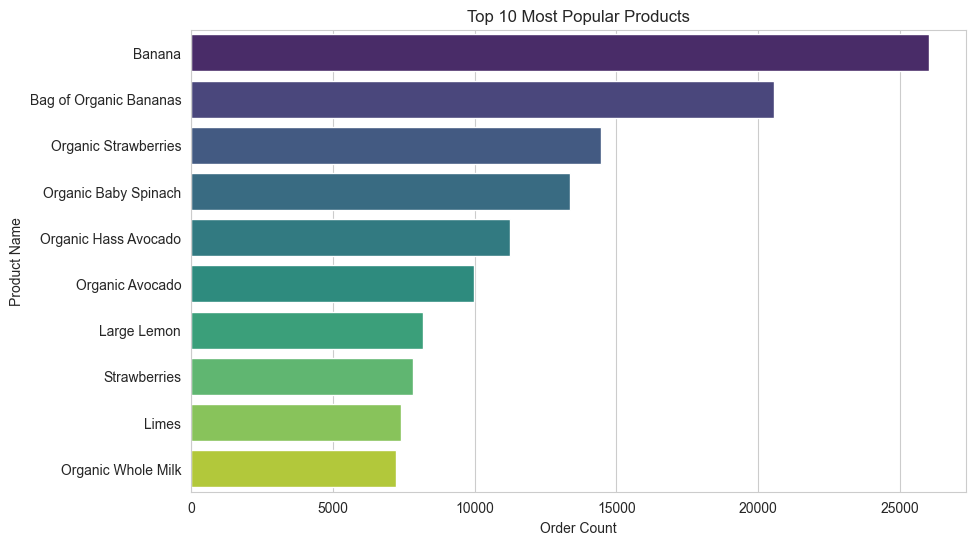

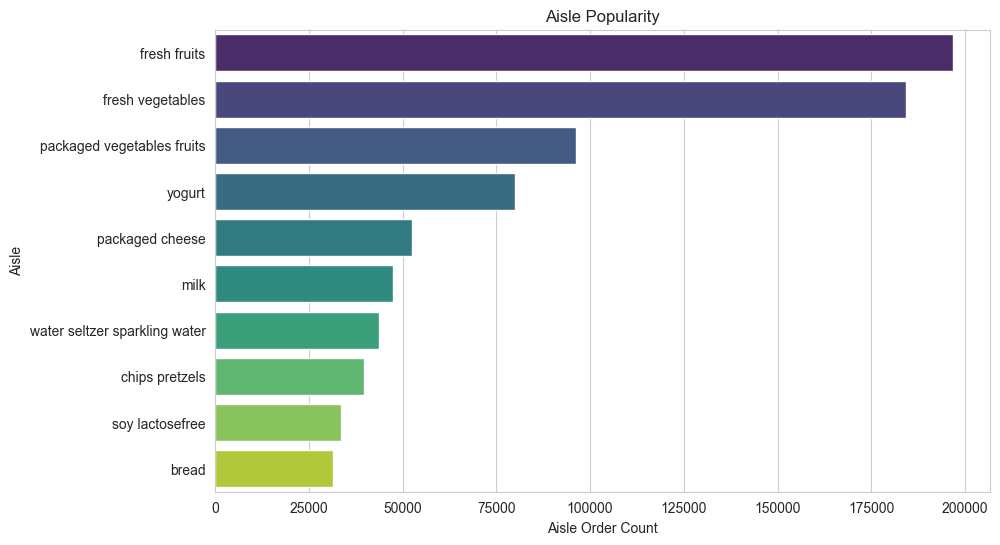

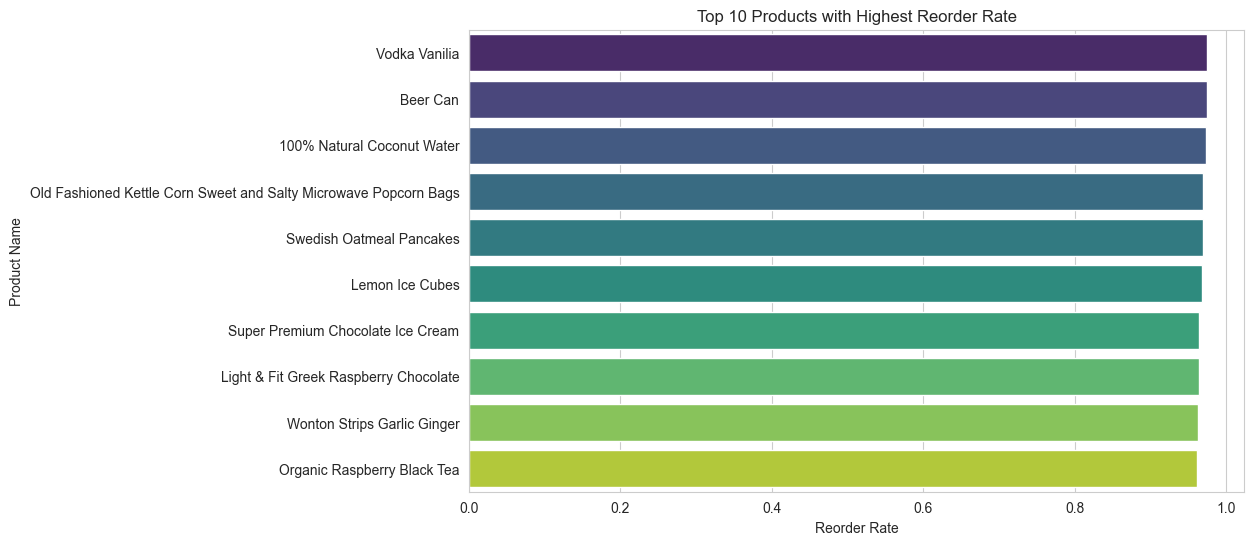

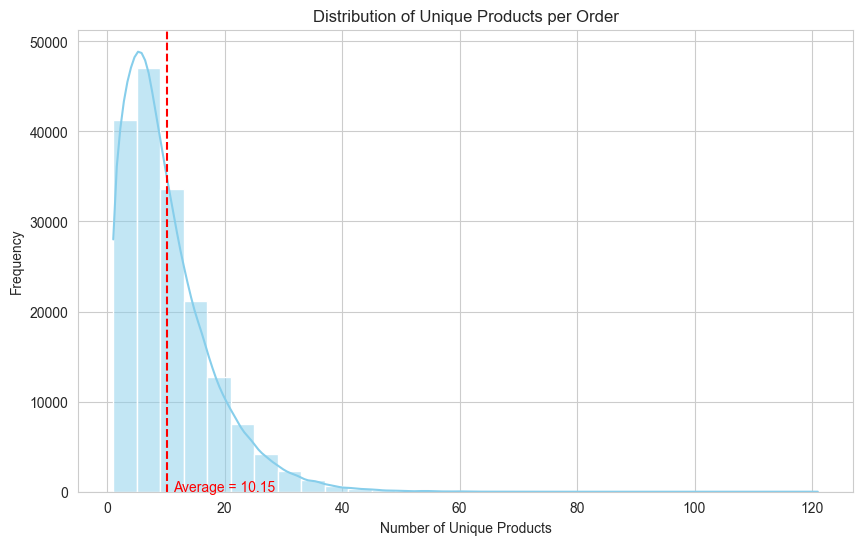

Average Number of Unique Products per Order: 10.15


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Most Popular Products
product_popularity = data_1['product_name'].value_counts().nlargest(10).reset_index()
product_popularity.columns = ['product_name', 'order_count']
plt.figure(figsize=(10, 6))
sns.barplot(data=product_popularity, x='order_count', y='product_name', palette='viridis')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Order Count')
plt.ylabel('Product Name')
plt.show()

# Most Popular Aisles
aisle_popularity = data_1['aisle'].value_counts().nlargest(10).reset_index()
aisle_popularity.columns = ['aisle', 'aisle_order_count']
plt.figure(figsize=(10, 6))
sns.barplot(data=aisle_popularity, x='aisle_order_count', y='aisle', palette='viridis')
plt.title('Aisle Popularity')
plt.xlabel('Aisle Order Count')
plt.ylabel('Aisle')
plt.show()

# Reorder Rates of Products
product_reorder = data_1.groupby('product_name')['reordered'].mean().reset_index()
product_reorder.columns = ['product_name', 'reorder_rate']
product_reorder = product_reorder.sort_values(by='reorder_rate', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=product_reorder, x='reorder_rate', y='product_name', palette='viridis')
plt.title('Top 10 Products with Highest Reorder Rate')
plt.xlabel('Reorder Rate')
plt.ylabel('Product Name')
plt.show()

# Diversity of Products in Baskets
order_product_diversity = data_1.groupby('order_id')['product_id'].nunique().reset_index()
order_product_diversity.columns = ['order_id', 'unique_products_count']
average_product_diversity = order_product_diversity['unique_products_count'].mean()

# Distribution of Unique Products per Order
plt.figure(figsize=(10, 6))
sns.histplot(order_product_diversity['unique_products_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Unique Products per Order')
plt.xlabel('Number of Unique Products')
plt.ylabel('Frequency')
plt.axvline(average_product_diversity, color='red', linestyle='--')
plt.text(average_product_diversity+1, 5, f'Average = {average_product_diversity:.2f}', color='red')
plt.show()

print(f"Average Number of Unique Products per Order: {average_product_diversity:.2f}")

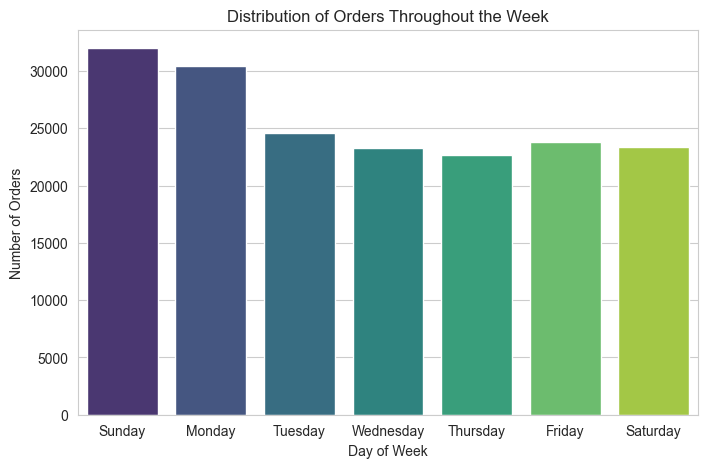

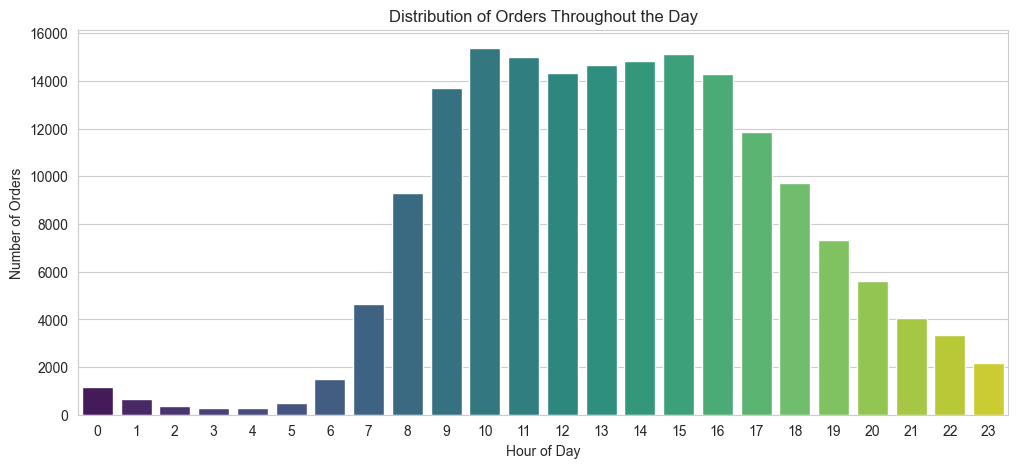

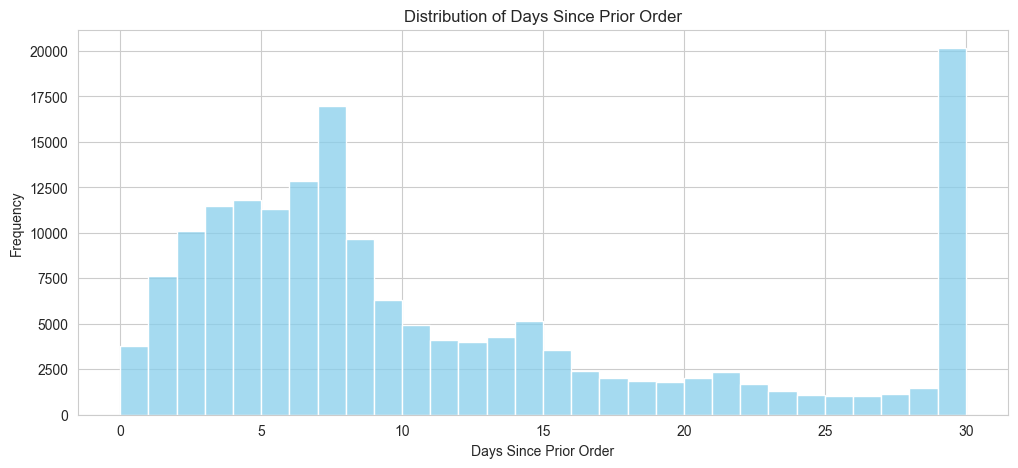

In [23]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Distribution of Orders Throughout the Week
plt.figure(figsize=(8, 5))
sns.countplot(x='order_dow', data=filtered_orders, palette='viridis')
plt.title('Distribution of Orders Throughout the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
# Optionally, you can set the xtick labels to the corresponding day names if you know the mapping
plt.xticks(ticks=range(0, 7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

# Distribution of Orders Throughout the Day
plt.figure(figsize=(12, 5))
sns.countplot(x='order_hour_of_day', data=filtered_orders, palette='viridis')
plt.title('Distribution of Orders Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()

# Distribution of Days Since Prior Order
plt.figure(figsize=(12, 5))
sns.histplot(x='days_since_prior_order', data=filtered_orders, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.show()


<div class="alert alert-block alert-success"><strong> Association Mining - Product level </strong> <br>
What products appear most frequently together?

In [24]:
pip install efficient_apriori

Note: you may need to restart the kernel to use updated packages.


In [25]:
from efficient_apriori import apriori

# Aggregate the data into transactions using product_id
transactions = data_1.groupby('order_id')['product_id'].apply(list).values.tolist()

# Apply the Apriori algorithm using product IDs
itemsets, rules = apriori(transactions, min_support=0.01, min_confidence=0.01)

# Function to translate product IDs to product names in an itemset or rule
def translate_product_names(itemset_or_rule):
    return [data_1.loc[data_1['product_id'] == item, 'product_name'].values[0] for item in itemset_or_rule]

# Convert the itemsets from product_ids to product_names
itemsets_with_names = {}
for key, itemset in itemsets.items():
    itemsets_with_names[key] = {tuple(translate_product_names(items)): support for items, support in itemset.items()}

# Print out the result with product names
print("Frequent Itemsets:")
for key, value in itemsets_with_names.items():
    print(f"Itemsets of length {key}:")
    for itemset, support in value.items():
        print(f"{itemset} - Support: {support}")

print("\nAssociation Rules:")
for rule in sorted(rules, key=lambda rule: rule.lift):
    lhs_names = translate_product_names(rule.lhs)
    rhs_names = translate_product_names(rule.rhs)
    print(f"{' , '.join(lhs_names)} => {' , '.join(rhs_names)} (Support: {rule.support}, Confidence: {rule.confidence}, Lift: {rule.lift})")

# If you need to see rules in a DataFrame with names
rules_df = pd.DataFrame(
    [{'Left hand side': translate_product_names(rule.lhs), 
      'Right hand side': translate_product_names(rule.rhs), 
      'Support': rule.support, 
      'Confidence': rule.confidence, 
      'Lift': rule.lift} for rule in rules]
)

print(rules_df.head())


Frequent Itemsets:
Itemsets of length 1:
('Cucumber Kirby',) - Support: 5465
('Bag of Organic Bananas',) - Support: 20576
('Organic Hass Avocado',) - Support: 11239
('Organic Whole String Cheese',) - Support: 3077
('Soda',) - Support: 1907
('Sparkling Natural Mineral Water',) - Support: 2193
('Raspberries',) - Support: 3176
('Organic Whole Milk',) - Support: 7249
('Banana',) - Support: 26026
('Organic Blackberries',) - Support: 3274
('Unsweetened Almondmilk',) - Support: 2692
('Organic Strawberries',) - Support: 14478
('Organic Kiwi',) - Support: 2851
('Strawberries',) - Support: 7822
('Organic Baby Carrots',) - Support: 4196
('Organic Unsweetened Almond Milk',) - Support: 3244
('Organic Raspberries',) - Support: 6997
('Uncured Genoa Salami',) - Support: 2106
('Organic Garlic',) - Support: 5973
('Organic Italian Parsley Bunch',) - Support: 3343
('Organic Yellow Onion',) - Support: 5953
('Organic Zucchini',) - Support: 5781
('Organic Fuji Apple',) - Support: 4918
('Organic Baby Spinach'

             Left hand side           Right hand side   Support  Confidence  \
0    [Organic Strawberries]  [Bag of Organic Bananas]  0.020518    0.244578   
1  [Bag of Organic Bananas]    [Organic Strawberries]  0.020518    0.172094   
2    [Organic Baby Spinach]  [Bag of Organic Bananas]  0.015002    0.193469   
3  [Bag of Organic Bananas]    [Organic Baby Spinach]  0.015002    0.125826   
4     [Organic Raspberries]  [Bag of Organic Bananas]  0.012493    0.308132   

      Lift  
0  2.05136  
1  2.05136  
2  1.62269  
3  1.62269  
4  2.58441  


<div class="alert alert-block alert-success">

1. **Strong Association with Organic Products**: There is a significant trend of customers buying organic products together. Items like 'Organic Baby Spinach,' 'Organic Hass Avocado,' and 'Organic Strawberries' appear frequently alongside 'Bag of Organic Bananas.' This suggests a customer segment highly interested in organic produce.

2. **Bananas as a Central Item**: Bananas, both organic and regular, are often purchased with various other items. The frequent pairing of bananas with items like 'Organic Avocado,' 'Organic Baby Spinach,' 'Organic Strawberries,' and even 'Organic Fuji Apple' indicates that bananas may be a staple item in many customers' shopping, acting as a complementary product for a wide range of baskets.

3. **High Confidence in Organic Pairings**: There is a notable confidence level in the association between 'Organic Hass Avocado' and 'Bag of Organic Bananas.' With nearly 30% confidence, when customers buy 'Organic Hass Avocado,' they are also likely to buy 'Bag of Organic Bananas.' This pattern suggests that promotions targeting one of these items might effectively drive sales of the other.

4. **Lift Values Indicate Stronger than Chance Pairings**: The lift values are all above 1, which suggests that the association between these items is stronger than would be expected by chance alone. For example, the lift value of approximately 2.47 for 'Organic Hass Avocado' and 'Bag of Organic Bananas' means that the likelihood of these two items being purchased together is about 2.47 times greater than what would be expected if they were statistically independent.

5. **Opportunities for Cross-Promotion and Marketing Strategies**: The data offers valuable insights for cross-promotion and marketing. For instance, since 'Organic Baby Spinach' and 'Bag of Organic Bananas' are often purchased together, placing these items near each other in the store or featuring them in the same promotional material could potentially increase sales. Similarly, discount bundles or loyalty rewards for purchasing certain item combinations could cater to the observed buying habits.

Overall, these insights suggest a strong pattern of combined purchases, especially among organic products, with bananas playing a central role in these combinations. This information can help in inventory management, targeted promotions, and enhancing the shopping experience for customers likely to buy these product combinations.

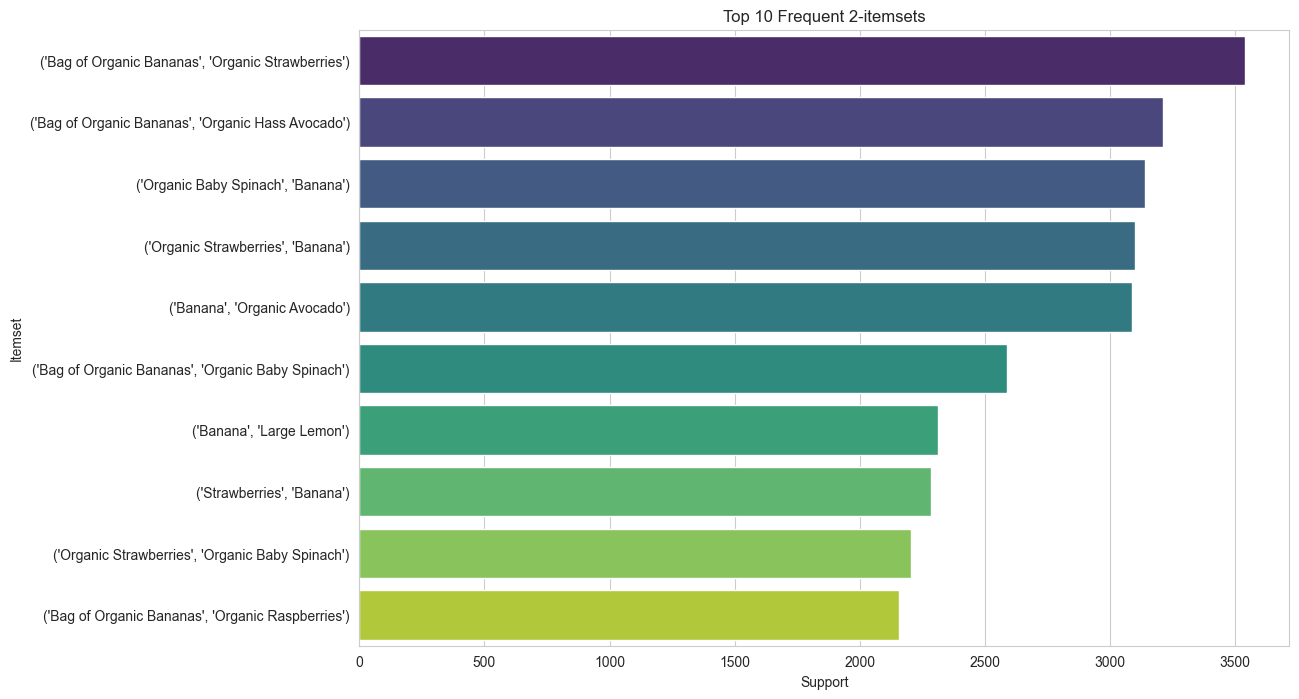

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the support values for 1-itemsets to visualize
itemset_supports = itemsets_with_names[2]  # You could change the number to visualize 2-itemsets or more

# Convert the dictionary to a DataFrame for visualization
itemset_support_df = pd.DataFrame(itemset_supports.items(), columns=['Itemset', 'Support'])

# Sort the itemsets by support
itemset_support_df = itemset_support_df.sort_values(by='Support', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Support', y='Itemset', data=itemset_support_df, palette='viridis')
plt.title('Top 10 Frequent 2-itemsets')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()


/var/folders/vl/q57w49ys18v2dbmv_5lg2wth0000gn/T/ipykernel_93744/2512687980.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 10)  # Get 10 color shades from the 'viridis' colormap


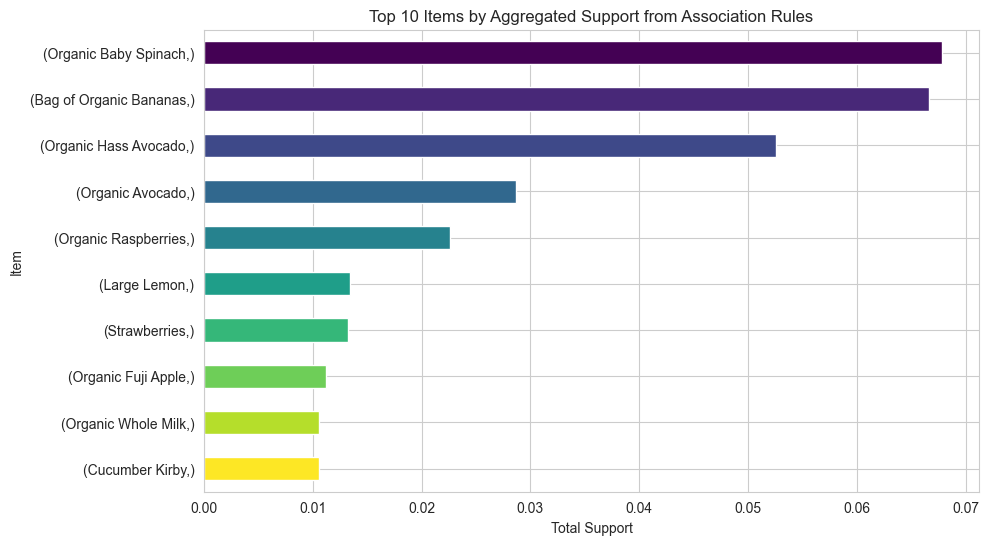

In [29]:
import matplotlib.cm as cm
# Assuming 'rules_df' is your DataFrame and it's already defined
# Convert lists in 'Left hand side' to tuples, which are hashable
rules_df['Left hand side'] = rules_df['Left hand side'].apply(tuple)

# Now, perform the groupby operation
rule_support = rules_df.groupby('Left hand side')['Support'].sum()

# Sort the aggregated support values from highest to lowest
rule_support = rule_support.sort_values(ascending=False)

# Pick the top 10, which will be the last 10 items due to the sort order
rule_support_top10 = rule_support.tail(10)

# Get the 'viridis' colormap
viridis = cm.get_cmap('viridis', 10)  # Get 10 color shades from the 'viridis' colormap

# Apply colormap to the top 10 items
colors = viridis(np.linspace(0, 1, 10))  # Generate colors from the colormap

# Plot with the highest value at the bottom and apply the colors
rule_support_top10.plot(kind='barh', figsize=(10, 6), color=colors)

plt.title('Top 10 Items by Aggregated Support from Association Rules')
plt.xlabel('Total Support')
plt.ylabel('Item')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest value at the bottom
plt.show()

<div class="alert alert-block alert-success">
    
<strong>Popularity of Items:</strong> The items that appear at the top of the bar chart are the ones that are most frequently purchased in combination with other items. They are central players in the set of rules generated by the Apriori algorithm, indicating their strong presence in the shopping baskets.

<strong>Strength of Association:</strong> The length of the bar represents the total support for each item, which is an aggregate measure of how often these items appear across all transactions. A longer bar means the item is part of many transactions and thus has a higher chance of being bought with various other items.

<strong>Key Influencers in the Basket:</strong> Items with the highest aggregated support are likely to be the ones influencing the presence of other items in the basket. If you see an item with a significantly longer bar, it's not just popular on its own; it's also likely to be a key product that pulls in sales of other products.

<div class="alert alert-block alert-success"><strong> Association Mining - Department level </strong><br>
What departments appear most frequently together?

In [ ]:
# Aggregate the data into transactions using department_name
transactions = data_1.groupby('order_id')['department'].apply(list).values.tolist()

# Apply the Apriori algorithm using department names
itemsets, rules = apriori(transactions, min_support=0.01, min_confidence=0.01)

# Since we are using names directly, we don't need to translate them.
# Print out the result with department names
print("Frequent Itemsets:")
for key, value in itemsets.items():
    print(f"Itemsets of length {key}:")
    for itemset, support in value.items():
        print(f"{itemset} - Support: {support}")

print("\nAssociation Rules:")
for rule in sorted(rules, key=lambda rule: rule.lift):
    print(f"{' , '.join(rule.lhs)} => {' , '.join(rule.rhs)} "
          f"(Support: {rule.support}, Confidence: {rule.confidence}, Lift: {rule.lift})")

# If you need to see rules in a DataFrame
rules_df = pd.DataFrame(
    [{'Left hand side': rule.lhs, 
      'Right hand side': rule.rhs, 
      'Support': rule.support, 
      'Confidence': rule.confidence, 
      'Lift': rule.lift} for rule in rules]
)

print(rules_df.head())


In [ ]:
# Extract top 10 frequent 2-itemsets
two_itemsets = itemsets.get(2, {})
top_two_itemsets = sorted(two_itemsets.items(), key=lambda x: x[1], reverse=True)[:10]

# Prepare the data for visualization
itemsets_labels = [' & '.join(itemset) for itemset, support in top_two_itemsets]
itemsets_supports = [support for itemset, support in top_two_itemsets]

# Visualize top 10 frequent 2-itemsets
plt.figure(figsize=(10, 6))
sns.barplot(x=itemsets_supports, y=itemsets_labels, palette='viridis')
plt.title('Top 10 Frequent 2-itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

# Extract departments and their supports from rules
department_supports = {}
for rule in rules:
    # For simplicity, we consider rules with a single department on the left-hand side
    if len(rule.lhs) == 1 and len(rule.rhs) == 1:
        department = rule.lhs[0]
        support = rule.support
        department_supports[department] = department_supports.get(department, 0) + support

# Extract top 10 departments by aggregated support
top_departments = sorted(department_supports.items(), key=lambda x: x[1], reverse=True)[:10]

# Prepare the data for visualization
departments_labels = [dep[0] for dep in top_departments]
departments_supports = [dep[1] for dep in top_departments]

# Visualize top 10 departments by aggregated support
plt.figure(figsize=(10, 6))
sns.barplot(x=departments_supports, y=departments_labels, palette='mako')
plt.title('Top 10 Departments by Aggregated Support')
plt.xlabel('Aggregated Support')
plt.ylabel('Departments')
plt.show()


<div class="alert alert-block alert-success"><strong> Sequential Mining - User id and order level </strong><br>
What departments appear most frequently together?

In [ ]:
import pandas as pd
from prefixspan import PrefixSpan

# Create a mapping from product_id to product_name
product_name_mapping = pd.Series(data_1.product_name.values, index=data_1.product_id).to_dict()

# Sort prior orders by user and then by order number
data_1 = data_1.sort_values(by=['user_id', 'order_number'])

# Create a sequence of products for each order and include the user_id
order_sequences = data_1.groupby(['user_id', 'order_id'])['product_id'].apply(list).reset_index(name='product_sequence')

# Extracting sequences for PrefixSpan
sequences_for_mining = order_sequences['product_sequence'].tolist()

ps = PrefixSpan(sequences_for_mining)

# Get all frequent sequences with a minimum frequency (e.g., 1000)
frequent_sequences = ps.frequent(1000)

# Filter out sequences with only one product AFTER finding frequent sequences
frequent_sequences = [fs for fs in frequent_sequences if len(fs[1]) > 1]

# Sort sequences by their frequency
sorted_sequences = sorted(frequent_sequences, key=lambda x: x[0], reverse=True)

# Replace product_ids with product_names in the sequences
def replace_with_names(sequence):
    return [product_name_mapping.get(product_id, "Unknown") for product_id in sequence]

# Apply the function to all sequences in sorted_sequences
named_sequences = [(freq, replace_with_names(seq)) for freq, seq in sorted_sequences]

# Now filter the sorted named sequences into separate lists for 2, 3, and 4 items
sequences_with_2_items = [seq for seq in named_sequences if len(seq[1]) == 2][:10]
sequences_with_3_items = [seq for seq in named_sequences if len(seq[1]) == 3][:5]
sequences_with_4_items = [seq for seq in named_sequences if len(seq[1]) == 4][:5]

# Function to print the sequences in a nice format
def print_top_sequences(sequences):
    for freq, seq in sequences:
        print(f"Frequency: {freq}, Sequence: {', '.join(seq)}")

# Print the top 5 sequences with 2, 3, and 4 items
print("Top 10 sequences with 2 items:")
print_top_sequences(sequences_with_2_items)

print("\nTop 5 sequences with 3 items:")
print_top_sequences(sequences_with_3_items)

print("\nTop 5 sequences with 4 items:")
print_top_sequences(sequences_with_4_items)


In [ ]:
# Function to plot sequences with 'viridis' colormap
def plot_top_sequences(sequences):
    # Split the sequences and their frequencies
    frequencies = [freq for freq, _ in sequences]
    sequence_labels = [', '.join(seq) for _, seq in sequences]

    # Generate a sequence of numbers from 0 to 1
    color_range = np.linspace(0, 1, len(frequencies))

    # Create the bar chart with 'viridis' colormap
    plt.figure(figsize=(10, 6))
    plt.bar(sequence_labels, frequencies, color=plt.cm.viridis(color_range))

    # Add title and labels
    plt.title('Top 10 Sequences with 2 Items')
    plt.xlabel('Item Sequences')
    plt.ylabel('Frequencies')
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming sequences_with_2_items is already defined from the previous step
plot_top_sequences(sequences_with_2_items)


<div class="alert alert-block alert-success">
    
**Organic Dominance:** There's a strong preference for organic products among customers, with each of the top sequences featuring at least one organic item. This indicates a health-conscious customer base that prioritizes organic produce when shopping.

**Banana Bonanza:** Bananas, both organic and conventional, are clear staples in customers' baskets, featuring in three of the top five sequences. This highlights the fruit's versatility and popularity, suggesting it's a must-stock item for any grocery store.

**Berry Connection:** The pairing of organic strawberries with other items twice in the top sequences reveals a pattern of customers combining these berries with staple products. It could signal a trend of berries being perceived as both a healthy and a complementary item, perhaps for breakfasts or smoothies.

**The Avocado Affinity:** The presence of avocados in two sequences suggests they're not just a fad but a sustained preference among shoppers. The organic Hass variety, in particular, may have a perceived value of quality or taste that justifies its position in the ranking.

**Spinach Pairing:** The combination of bananas with organic baby spinach might hint at the popularity of these items in 'green' smoothies or health-focused meal planning, showcasing a consumer interest in nutrient-dense, convenient food options.

In [30]:
data_1.head()

,order_id,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id,set,product_name,aisle_id,department_id,aisle,department
0,13,17330,1,0,2,6,17,1.0,45082,train,Light,27,5,beers coolers,alcohol
1,13,27407,2,0,2,6,17,1.0,45082,train,Chunky Salsa Medium,51,13,preserved dips spreads,pantry
2,13,35419,3,0,2,6,17,1.0,45082,train,"Handmade Vodka From Austin, Texas",124,5,spirits,alcohol
3,13,196,4,0,2,6,17,1.0,45082,train,Soda,77,7,soft drinks,beverages
4,13,44635,5,0,2,6,17,1.0,45082,train,Salsa Con Queso Medium Dip,51,13,preserved dips spreads,pantry


In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming data_1 is already loaded and is your dataset

# Step 1: Feature Engineering
# Create a customer-level DataFrame with necessary features

# Here's an example of creating a simple feature set:
user_features = data_1.groupby('user_id').agg({
    'order_id': pd.Series.nunique,
    'product_id': pd.Series.nunique,
    'add_to_cart_order': 'mean',
    'reordered': 'sum',
    'days_since_prior_order': 'mean'
}).rename(columns={
    'order_id': 'total_orders',
    'product_id': 'total_unique_products',
    'add_to_cart_order': 'average_cart_position',
    'reordered': 'total_reorders',
    'days_since_prior_order': 'average_days_between_orders'
}).reset_index()

# Step 2: Prepare the DataFrame for clustering
# No further action needed if using the DataFrame 'user_features' as prepared above

# Step 3: Preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_features.drop('user_id', axis=1))

# Step 4: Apply K-means Clustering
# Determine the optimal number of clusters, k (not shown here)
kmeans = KMeans(n_clusters=5, random_state=42)
user_features['cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate silhouette score
print(f"Silhouette Score: {silhouette_score(scaled_features, user_features['cluster'])}")

# Now you have a 'cluster' column in 'user_features' which indicates the cluster each user belongs to.


/Users/barnana/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.29688891650861277


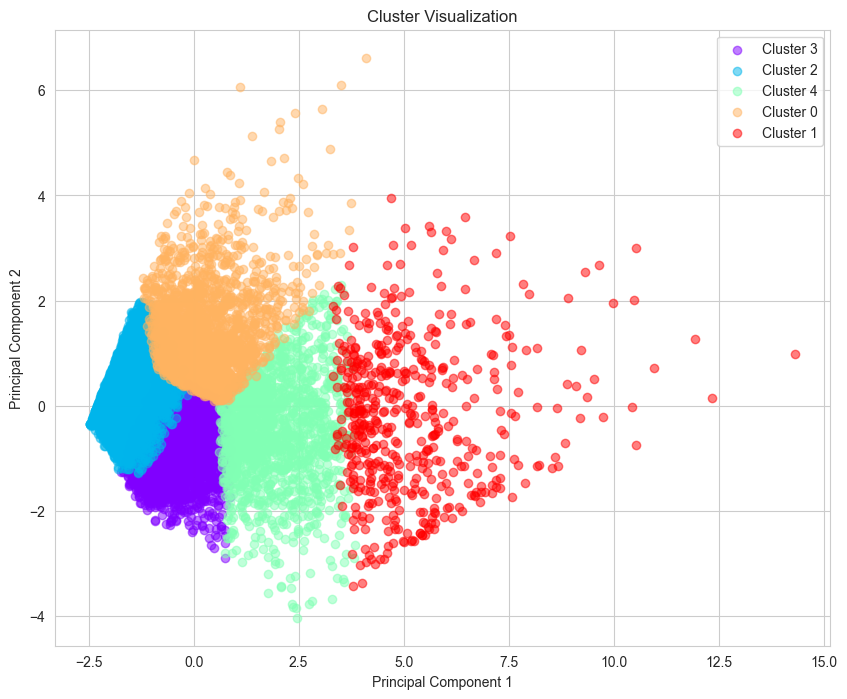

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Let's assume you have the 'scaled_features' from the previous steps and 'kmeans' model is already fitted

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Add the cluster information from the KMeans model
principal_df['cluster'] = user_features['cluster']

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.title('Cluster Visualization')

# Color map for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(principal_df['cluster'].unique())))

for color, cluster in zip(colors, principal_df['cluster'].unique()):
    plt.scatter(principal_df.loc[principal_df['cluster'] == cluster, 'principal_component_1'], 
                principal_df.loc[principal_df['cluster'] == cluster, 'principal_component_2'], 
                label=f'Cluster {cluster}', 
                alpha=0.5, 
                color=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-success">

<strong>Collaborative Filtering Recommendation System</strong>:
This implements a collaborative filtering recommendation system using user-product interaction data. The recommendation is based on the premise that users with similar purchase histories are likely to have similar preferences. Here's how the system works:

<strong>Step 1: User-Product Interaction Matrix</strong>
We start by creating a user-product interaction matrix from the data. Each row represents a user, each column represents a product, and the cells contain the count of how often a user has ordered a given product. This matrix serves as the foundation for identifying user preferences.

<strong>Step 2: Cosine Similarity</strong>
We then calculate the cosine similarity between users, which measures the cosine of the angle between two users' vectors in the interaction space. A value closer to 1 implies greater similarity. This similarity matrix is used to find users who are most similar to each other.

<strong>Step 3: Recommend Products</strong>
A function is defined to recommend products to a user. It performs the following operations:

Validates if the user exists in the interaction matrix.
Identifies similar users based on the cosine similarity matrix.
Computes a weighted sum of product scores based on similar users' interactions.
Filters out products that the target user has already interacted with.The rationale behind this is that recommending a product the user has already bought may not be as valuable as recommending new items that they are likely to be interested in.
Recommends the top N products with the highest scores.

<strong>Step 4: Generate Recommendations</strong>
Finally, we use the function to generate product recommendations for a given user. If the product names are available, we can map the recommended product IDs back to their names for a more user-friendly output.

In [40]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming data_1 is already loaded and is your dataset with columns 'user_id' and 'product_id'

# Step 1: Create the user-product interaction matrix
interaction_matrix = pd.pivot_table(data=data_1, 
                                    values='order_id', 
                                    index='user_id', 
                                    columns='product_id', 
                                    aggfunc='count', 
                                    fill_value=0)

# Step 2: Calculate the cosine similarity between users
user_similarity = cosine_similarity(interaction_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=interaction_matrix.index, 
                                  columns=interaction_matrix.index)

# Step 3: Make a function to recommend products for a user
def recommend_products(user_id, interaction_matrix, user_similarity_df, top_n=5):
    if user_id not in interaction_matrix.index:
        raise ValueError(f"User ID {user_id} is not present in the interaction matrix.")
        
    # Find the most similar users
    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False).iloc[1:]
    
    # Calculate a weighted sum of the ratings given by similar users
    product_scores = interaction_matrix.loc[similar_users.index].T.dot(similar_users)
    
    # Products that the user has not interacted with yet
    non_interacted_products = product_scores.index[interaction_matrix.loc[user_id] == 0]
    
    # Recommend the top N products with the highest weighted scores
    recommended_products = product_scores.loc[non_interacted_products].sort_values(ascending=False).head(top_n).index.tolist()
    
    return recommended_products

In [38]:
# Step 4: Use the function to get recommendations for a specific user
try:
    user_id_to_recommend = 45082  # Replace with the user ID for which you want recommendations
    top_5_products = recommend_products(user_id_to_recommend, interaction_matrix, user_similarity_df)
    
    # Convert product_ids to product names if you have that information available
    product_names = data_1[['product_id', 'product_name']].drop_duplicates().set_index('product_id')
    recommended_product_names = product_names.loc[top_5_products]['product_name'].values.tolist()
    
    print(f"Top 5 recommended products for user {user_id_to_recommend}: {recommended_product_names}")
except ValueError as e:
    print(e)


Top 5 recommended products for user 45082: ['Organic Strawberries', 'Organic Baby Spinach', 'Organic Avocado', 'Strawberries', 'Bag of Organic Bananas']
